### Regression Total population on distribution of Males across the counties in the US

Ordinarily the bandwidth for the new algo should be very large. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from gwr import GWR

from sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline



pop_data1 = pd.read_csv('./data/total_pop_mf.csv').drop('geometry', axis=1)

In [2]:
counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)



empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]

counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

pop_data1 = pop_data1.merge(counties_non_empty, left_on='GEOID', right_on='id', how='inner')
pop_data1.drop(['name', 'id'], axis=1, inplace=True)

pop_data1.drop(pop_data1[(pop_data1.GEOID >= 15000) & (pop_data1.GEOID < 16000)].index, inplace=True) # get rid of Hawaii
pop_data1.drop(pop_data1[(pop_data1.GEOID >= 2000) & (pop_data1.GEOID < 4000)].index, inplace=True) # get rid of Hawaii

pop_data1['totalp'] = pop_data1['P012002'] + pop_data1['P012026']
pop_data1 = gpd.GeoDataFrame(pop_data1, crs="EPSG:4326")



In [3]:
pop_data1.head()

,GEOID,P012002,P012026,NAME,state,county,geometry,lon,lat,totalp
0,1077,44379.0,48330.0,"Lauderdale County, Alabama",1,77,"POLYGON ((-87.98645 35.00575, -87.60599 35.004...",-87.654681,34.901303,92709.0
1,1105,4980.0,5611.0,"Perry County, Alabama",1,105,"POLYGON ((-87.42293 32.87442, -87.31884 32.875...",-87.294236,32.639178,10591.0
2,1053,19766.0,18553.0,"Escambia County, Alabama",1,53,"POLYGON ((-87.61675 31.24478, -87.55933 31.227...",-87.162772,31.126057,38319.0
3,1089,164320.0,170491.0,"Madison County, Alabama",1,89,"POLYGON ((-86.78404 34.992, -86.31743 34.99114...",-86.550747,34.763769,334811.0
4,1037,5727.0,5812.0,"Coosa County, Alabama",1,37,"POLYGON ((-86.51843 33.02046, -86.51125 33.088...",-86.248270,32.936232,11539.0


### Modelling

In [4]:
g_y = pop_data1["totalp"].values.reshape((-1,1))
g_X = pop_data1[["P012002"]].values

# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = pop_data1["lon"]
v = pop_data1["lat"]

g_coords = list(zip(u,v))

In [5]:
%%time
gwr_selector_o = Sel_BW(g_coords, g_y, g_X, lwcc=False)
gwr_bw_o = gwr_selector_o.search(bw_min=None)
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()
gwr_results_o.summary()

46.24
Model type                                                         Gaussian
Number of observations:                                                3105
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       81674959679.028
Log-likelihood:                                                  -30930.646
AIC:                                                              61865.292
AICc:                                                             61867.300
BIC:                                                           81674934728.521
R2:                                                                   1.000
Adj. R2:                                                              1.000

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- -----

### GW Correlation Coefficient. Classic 

In [6]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_y, g_X))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
pop_data1['gwr_calc'] = corr_mat
corr_mat.mean(), corr_mat.min(), corr_mat.max()

(np.float64(0.9997652426558039),
 np.float64(0.994090786290487),
 np.float64(0.9999970483692999))

### Calculate GW CC using the new algorithm 

In [7]:
g_y = pop_data1["totalp"].values.reshape((-1,1))
g_X = pop_data1[["P012002"]].values

# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

In [8]:
%%time
gwr_selector_n = Sel_BW(g_coords, g_y, g_X, lwcc=True)
gwr_bw_n = gwr_selector_n.search(bw_min=None)
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit() 
gwr_results_n.summary()

3104.14
Model type                                                         Gaussian
Number of observations:                                                3105
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       81789777358.058
Log-likelihood:                                                  -30932.827
AIC:                                                              61867.654
AICc:                                                             61869.658
BIC:                                                           81789752399.511
R2:                                                                   1.000
Adj. R2:                                                              1.000

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---

In [9]:
corr = []
# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

for i in range(len(g_X)):
    corr_coef, _ = stats.pearsonr(g_X.flatten(), g_y.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

np.float64(0.9998666863899554)

In [10]:
pop_data1['new_algo_params'] = gwr_results_n.params

In [11]:
from utils import compare_stacked

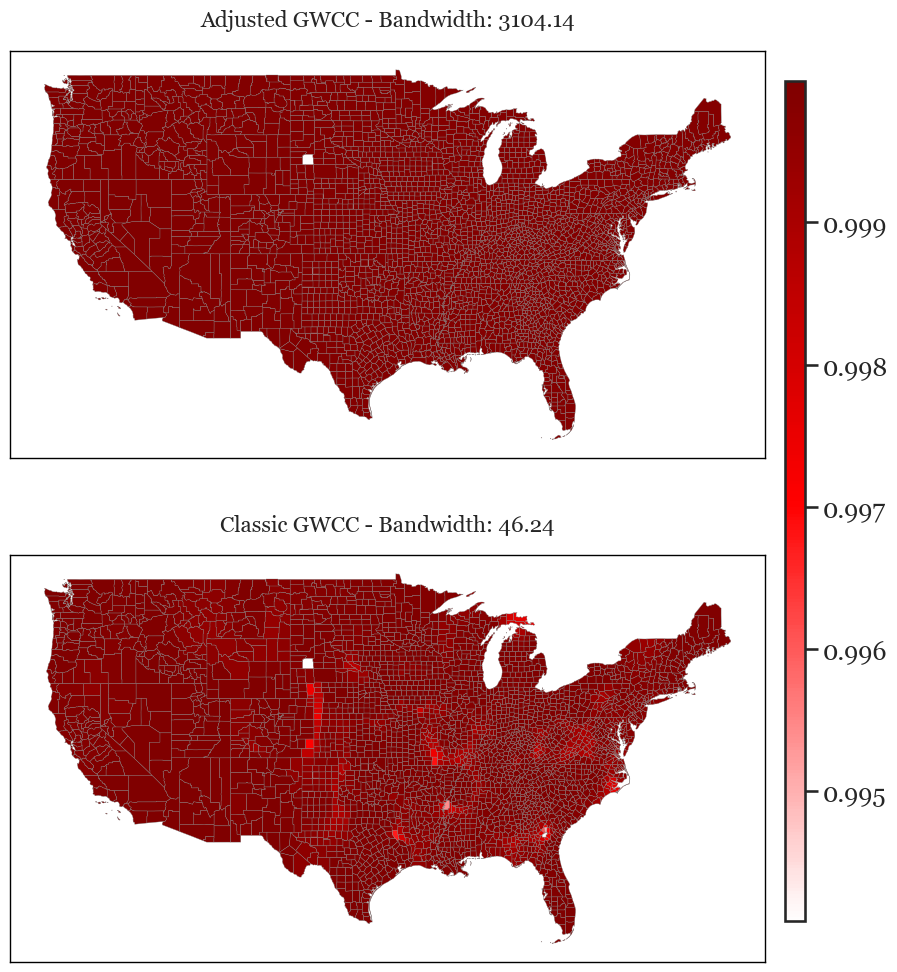

In [13]:
compare_stacked(pop_data1, 'new_algo_params', 'gwr_calc', gwr_bw_n, gwr_bw_o)